# Clothing Trade Network Creation

## Reading in and cleaning data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
df = pd.read_csv("trade_data_2000s.csv", index_col=0)

In [3]:
df

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
945000,3,6,1352,2003.0,0.0,4281.0,1.535351,0.268432,AIA,ANT,8423
945001,25,6,1352,2003.0,0.0,26220.0,0.308971,-0.561269,BHS,ANT,8423
945002,29,6,1352,2003.0,0.0,84921.0,-0.546138,-0.787781,BLZ,ANT,8423
945003,32,6,1352,2003.0,8011.0,0.0,0.636739,1.422593,BRA,ANT,8423
945004,33,6,1352,2003.0,0.0,2387.0,0.499073,-0.065065,BRB,ANT,8423
...,...,...,...,...,...,...,...,...,...,...,...
3982467,166,242,1363,2019.0,2379.0,0.0,0.099708,0.079208,NZL,WSM,8443
3982468,127,210,1363,2019.0,0.0,2392.0,0.263772,-0.709830,LCA,SXM,8443
3982469,231,210,1363,2019.0,11067.0,0.0,1.528196,0.297825,USA,SXM,8443
3982470,77,27,1363,2019.0,1706.0,0.0,1.345057,1.075400,FRA,BLM,8443


In [4]:
#grouping data by countries and year and taking sum so we just get total export and import values across all goods
df_grouped = df.groupby(['location_id', 'partner_id','year']).sum().reset_index()

In [5]:
#removing unnecessary columns
df_grouped_first = df_grouped.drop(['sitc_eci', 'sitc_coi','location_code','partner_code','sitc_product_code'], axis=1)
df_grouped_second = df_grouped_first.copy()

In [6]:
df_grouped_first

,location_id,partner_id,year,product_id,export_value,import_value
0,0,6,2005.0,31389,860510.0,3276527.0
1,0,6,2006.0,30017,1027015.0,96392.0
2,0,6,2007.0,30006,1014011.0,257016.0
3,0,6,2008.0,27280,1216843.0,103197.0
4,0,6,2009.0,34065,124191.0,3156666.0
...,...,...,...,...,...,...
388479,250,249,2014.0,32736,1921886.0,247429.0
388480,250,249,2015.0,32730,1593013.0,195494.0
388481,250,249,2016.0,30021,2281034.0,1948209.0
388482,250,249,2017.0,31346,1438130.0,1628499.0


In [7]:
#merging so that each row shows imports and exports for both countries involved in bilateral trade relationship
new_df = pd.merge(df_grouped_first, df_grouped_second,  how='left', left_on=['location_id','partner_id','year'], right_on = ['partner_id','location_id','year'])

In [8]:
new_df

,location_id_x,partner_id_x,year,product_id_x,export_value_x,import_value_x,location_id_y,partner_id_y,product_id_y,export_value_y,import_value_y
0,0,6,2005.0,31389,860510.0,3276527.0,6,0,31389,3276527.0,860510.0
1,0,6,2006.0,30017,1027015.0,96392.0,6,0,30017,96392.0,1027015.0
2,0,6,2007.0,30006,1014011.0,257016.0,6,0,30006,257016.0,1014011.0
3,0,6,2008.0,27280,1216843.0,103197.0,6,0,27280,103197.0,1216843.0
4,0,6,2009.0,34065,124191.0,3156666.0,6,0,34065,3156666.0,124191.0
...,...,...,...,...,...,...,...,...,...,...,...
388479,250,249,2014.0,32736,1921886.0,247429.0,249,250,32736,247429.0,1921886.0
388480,250,249,2015.0,32730,1593013.0,195494.0,249,250,32730,195494.0,1593013.0
388481,250,249,2016.0,30021,2281034.0,1948209.0,249,250,30021,1948209.0,2281034.0
388482,250,249,2017.0,31346,1438130.0,1628499.0,249,250,31346,1628499.0,1438130.0


In [9]:
#dropping columns and renaming
final_df = new_df.drop(['location_id_y', 'partner_id_y','product_id_y','product_id_x'], axis=1)
final_df = final_df.rename(columns={'location_id_x': 'location_1', 
                                    'partner_id_x': 'location_2',
                                    'export_value_x':'export_ij',
                                    'export_value_y':'export_ji',
                                    'import_value_x':'import_ij',
                                    'import_value_y':'iimport_ji'})

In [10]:
final_df

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji
0,0,6,2005.0,860510.0,3276527.0,3276527.0,860510.0
1,0,6,2006.0,1027015.0,96392.0,96392.0,1027015.0
2,0,6,2007.0,1014011.0,257016.0,257016.0,1014011.0
3,0,6,2008.0,1216843.0,103197.0,103197.0,1216843.0
4,0,6,2009.0,124191.0,3156666.0,3156666.0,124191.0
...,...,...,...,...,...,...,...
388479,250,249,2014.0,1921886.0,247429.0,247429.0,1921886.0
388480,250,249,2015.0,1593013.0,195494.0,195494.0,1593013.0
388481,250,249,2016.0,2281034.0,1948209.0,1948209.0,2281034.0
388482,250,249,2017.0,1438130.0,1628499.0,1628499.0,1438130.0


## Creation of Network

In [11]:
#Edge weight that will be used in creation of network - used in past literature
final_df['edge_value'] = (final_df['export_ij']+final_df['export_ji']+final_df['import_ij']+final_df['iimport_ji'])/2

In [12]:
final_df

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji,edge_value
0,0,6,2005.0,860510.0,3276527.0,3276527.0,860510.0,4137037.0
1,0,6,2006.0,1027015.0,96392.0,96392.0,1027015.0,1123407.0
2,0,6,2007.0,1014011.0,257016.0,257016.0,1014011.0,1271027.0
3,0,6,2008.0,1216843.0,103197.0,103197.0,1216843.0,1320040.0
4,0,6,2009.0,124191.0,3156666.0,3156666.0,124191.0,3280857.0
...,...,...,...,...,...,...,...,...
388479,250,249,2014.0,1921886.0,247429.0,247429.0,1921886.0,2169315.0
388480,250,249,2015.0,1593013.0,195494.0,195494.0,1593013.0,1788507.0
388481,250,249,2016.0,2281034.0,1948209.0,1948209.0,2281034.0,4229243.0
388482,250,249,2017.0,1438130.0,1628499.0,1628499.0,1438130.0,3066629.0


## Distance Metrics

### 1. Hamming Distance

In [13]:
def hamming_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            sum += abs(value_1-value_2)/(N*(N-1))
    
    return sum


### 2. Jaccard Distance

In [14]:
def jaccard_distance(G1, G2):
    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    N = len(t_1)

    sum = 0
    absolute_sum = 0
    maximum_sum = 0
    for row_1, row_2 in zip(t_1, t_2):
        for value_1, value_2 in zip(row_1, row_2):
            absolute_sum += abs(value_1-value_2)
            maximum_sum += max(value_1,value_2)
        
    sum += absolute_sum/maximum_sum

    return sum

### 3. Spanning Tree Dissimilarity

In [15]:
#Calculate the spanning tree number for each graph
def spanning_tree_num(G):
    eigenvalues = nx.normalized_laplacian_spectrum(G)
    nonzero_eig = eigenvalues[np.nonzero(eigenvalues)]
    N = len(nonzero_eig)
    
    product = 1
    for e in range(1,len(nonzero_eig)):
        product = product * nonzero_eig[e]

    return (1/N)*product

In [16]:
def st_distance(G1, G2):
    st_1 = spanning_tree_num(G1)
    st_2 = spanning_tree_num(G2)

    return abs(math.log(st_1)-math.log(st_2))

### 4. Polynomial Distance

In [17]:
#Calculate W
def calculate_w(eigenvalues, k, alpha):
    w = eigenvalues[0]
    n = len(eigenvalues)
    for i in range(2,k+1):
        coef = ((1/(n-1))**(alpha*(i-1)))
        w += coef*(eigenvalues[i-1]**(i))

    return w

In [18]:
#Calculate P
def calculate_p(w, q):
    q_w = np.dot(q,w)
    return np.dot(q_w, q.T)

In [19]:
def polynomial_distance(G1, G2):
    n = len(G1.nodes())

    t_1 = nx.to_numpy_array(G1)
    t_2 = nx.to_numpy_array(G2)

    eigvec_1 = np.linalg.eig(t_1)[1]
    eigenvals_1 = nx.laplacian_spectrum(G1)

    eigvec_2 = np.linalg.eig(t_2)[1]
    eigenvals_2 = nx.laplacian_spectrum(G2)

    t1_w = calculate_w(eigenvals_1, 5, 1)
    t2_w = calculate_w(eigenvals_2, 5, 1)

    t1_p = calculate_p(t1_w, eigvec_1)
    t2_p = calculate_p(t2_w, eigvec_2)

    return (1/n**2)*np.linalg.norm(t1_p-t2_p)

        

### Analyzing Distances

In [20]:
final_df

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji,edge_value
0,0,6,2005.0,860510.0,3276527.0,3276527.0,860510.0,4137037.0
1,0,6,2006.0,1027015.0,96392.0,96392.0,1027015.0,1123407.0
2,0,6,2007.0,1014011.0,257016.0,257016.0,1014011.0,1271027.0
3,0,6,2008.0,1216843.0,103197.0,103197.0,1216843.0,1320040.0
4,0,6,2009.0,124191.0,3156666.0,3156666.0,124191.0,3280857.0
...,...,...,...,...,...,...,...,...
388479,250,249,2014.0,1921886.0,247429.0,247429.0,1921886.0,2169315.0
388480,250,249,2015.0,1593013.0,195494.0,195494.0,1593013.0,1788507.0
388481,250,249,2016.0,2281034.0,1948209.0,1948209.0,2281034.0,4229243.0
388482,250,249,2017.0,1438130.0,1628499.0,1628499.0,1438130.0,3066629.0


In [21]:
locations = pd.read_stata("location_classifications/location.dta")

In [22]:
locations

,location_id,location_code,location_name_short_en,level,parent_id
0,0,ABW,Aruba,country,356.0
1,1,AFG,Afghanistan,country,353.0
2,2,AGO,Angola,country,352.0
3,3,AIA,Anguilla,country,356.0
4,4,ALB,Albania,country,355.0
...,...,...,...,...,...
253,354,3,Oceania,region,NaN
254,355,4,Europe,region,NaN
255,356,5,North America,region,NaN
256,357,6,South America,region,NaN


In [23]:
locations['location_id'] = pd.to_numeric(locations['location_id'])

In [24]:
result = pd.merge(final_df, locations, how="left", left_on ='location_1', right_on='location_id')

In [25]:
result = result[(result['parent_id']==355) | (result['parent_id']==356) | (result['parent_id']==353)]

In [26]:
result

,location_1,location_2,year,export_ij,import_ij,export_ji,iimport_ji,edge_value,location_id,location_code,location_name_short_en,level,parent_id
0,0,6,2005.0,860510.0,3276527.0,3276527.0,860510.0,4137037.0,0,ABW,Aruba,country,356.0
1,0,6,2006.0,1027015.0,96392.0,96392.0,1027015.0,1123407.0,0,ABW,Aruba,country,356.0
2,0,6,2007.0,1014011.0,257016.0,257016.0,1014011.0,1271027.0,0,ABW,Aruba,country,356.0
3,0,6,2008.0,1216843.0,103197.0,103197.0,1216843.0,1320040.0,0,ABW,Aruba,country,356.0
4,0,6,2009.0,124191.0,3156666.0,3156666.0,124191.0,3280857.0,0,ABW,Aruba,country,356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386569,249,250,2014.0,247429.0,1921886.0,1921886.0,247429.0,2169315.0,249,TWN,Taiwan,country,353.0
386570,249,250,2015.0,195494.0,1593013.0,1593013.0,195494.0,1788507.0,249,TWN,Taiwan,country,353.0
386571,249,250,2016.0,1948209.0,2281034.0,2281034.0,1948209.0,4229243.0,249,TWN,Taiwan,country,353.0
386572,249,250,2017.0,1628499.0,1438130.0,1438130.0,1628499.0,3066629.0,249,TWN,Taiwan,country,353.0


In [27]:
result = result[(result['year']>=2010)]

In [28]:
#Create weighted adjacency matrix for each year
connected_graphs = []
for i in sorted(result['year'].unique()):
    for j in sorted(result['parent_id'].unique()):
        df = result[(result['year']==i) & (result['parent_id']==j)]
        edges = pd.DataFrame(
            {
                "source": list(df['location_1']),
                "target": list(df['location_2']),
                "weight": list(df['edge_value'])
            }
        )
        G = nx.from_pandas_edgelist(edges, edge_attr=True)
        G.graph['year'] = int(i)
        G.graph['region'] = int(j)
        connected_graphs.append(G)

In [29]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    labels = []
    regions = []
    years = []
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        labels.append(f"{graphs[i].graph['year']}_{graphs[i].graph['region']}")
        regions.append(graphs[i].graph['region'])
        years.append(graphs[i].graph['year'])
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])

    return distances, labels, years, regions


In [30]:
def add_missing_node(graph, new_node):
    graph.add_node(new_node)
    return graph

In [31]:
def update_graph_with_missing_nodes(graph, nodes):
    missing_nodes = set(nodes) - set(graph.nodes())
    for node in missing_nodes:
        graph.add_node(node)

    return graph

In [32]:
def max_nodes(graphs):
    max_len = 0
    for i in graphs:
        temp = len(i)
        if temp > max_len:
            max_len = temp
            nodes = i.nodes()

    return nodes

In [33]:
def standardize_graph_len(graphs, nodes):
    updated_graphs = []
    for i in graphs:
        new_graph = update_graph_with_missing_nodes(i, nodes)
        updated_graphs.append(new_graph)

    return updated_graphs

### Heatmap

In [34]:
def consecutive_distances_regions(graphs, dist_type):
    consec_asia = []
    consec_na = []
    consec_eur = []

    asia_graphs = [x for x in graphs if x.graph['region'] == 353]
    europe_graphs = [x for x in graphs if x.graph['region'] == 355]
    na_graphs = [x for x in graphs if x.graph['region'] == 356]

    for i in range(len(asia_graphs)-1):
        consec_asia.append(dist_type(asia_graphs[i], asia_graphs[i+1]))

    for i in range(len(europe_graphs)-1):
        consec_eur.append(dist_type(europe_graphs[i], europe_graphs[i+1]))

    for i in range(len(na_graphs)-1):
        consec_na.append(dist_type(na_graphs[i], na_graphs[i+1]))

    return consec_asia, consec_eur, consec_na

In [35]:
import seaborn as sns
def pairwise_heatmap(distances, labels):
    sns.heatmap(distances, xticklabels=labels, yticklabels=labels)
    sns.set_theme(font_scale=0.6)

### MDS Projections

In [36]:
from sklearn.manifold import MDS 
def mds_projections(regions, distances):
  mds = MDS(n_components=2, random_state=0) 
  X_2d = mds.fit_transform(distances)

  markers = ["v","o","x","s",".","*","+","1","p","P","H","8"]
  colors = ['blue','green','red']
  region_labels = ["Asia","North America","Europe"]
  plt.rcParams['figure.figsize'] = [7, 7]
  plt.rc('font', size=14)
  for j,i in enumerate(np.unique(regions)):
    subset = X_2d[np.where(regions == i)[0]]
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]  
    for i in range(12):
      plt.scatter(x[i],y[i],c=colors[j],label=region_labels[j], marker=markers[i])
      
  plt.show()

In [37]:
def dist_line_graph(asia_dist, eur_dist, na_dist, dist_name):
    
    x = ["2010-2011","2011-2012","2012-2013","2013-2014","2014-2015","2015-2016","2016-2017","2017-2018","2018-2019","2019-2020","2020-2021"]

    plt.plot(x, asia_dist, label ='Asia')
    plt.plot(x, eur_dist, label ='Europe')
    plt.plot(x, na_dist, label ='North America')

    plt.xlabel("Years")
    plt.ylabel(f"{dist_name}")
    plt.legend()
    plt.title(f'{dist_name} of Region Graphs')
    plt.xticks(rotation=70)
    plt.show()

### Metagraph

In [38]:
def get_metagraph(distances, labels, regions):
    G_knn = nx.Graph()
    h_copy = distances[:]
    same_class = 0
    for j,row in enumerate(h_copy):
        start_node = labels[j]
        row[row == 0] = np.inf
        end_node = labels[np.argmin(row)]
        if regions[j]== regions[np.argmin(row)]:
            same_class += 1
        G_knn.add_edge(start_node, end_node)

    return same_class, G_knn

In [39]:
# separate calls to draw nodes and edges
def metagraph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_edges(G, pos)
    plt.show()

### Creating Random Graphs

In [40]:
import random
def random_graphs(metagraph):
    random_graphs = []
    for i in range(1000):
        # create a random mapping old label -> new label
        node_mapping = dict(zip(metagraph.nodes(), sorted(metagraph.nodes(), key=lambda k: random.random())))
        # build a new graph
        G_new = nx.relabel_nodes(metagraph, node_mapping)
        random_graphs.append(G_new)
    
    return random_graphs

In [41]:
def get_same_class_random(random_graphs):
    random_same_class = []
    for i in random_graphs:
        num_same = 0
        edges = list(i.edges())
        for e in edges:
            edge_1_region = e[0].split("_")[1]
            edge_2_region = e[1].split("_")[1]
            if edge_1_region==edge_2_region:
                num_same += 1
        random_same_class.append(num_same)
    
    return random_same_class

In [42]:
import seaborn as sns
def plot_random_dist(random_same_class):
    sns.displot(random_same_class, kde=True, bins=15)

### Friedman–Rafsky Test

In [43]:
import statistics 
import scipy.stats 

def fr_test(num_random, num_observed):
    sd_random = statistics.pstdev(num_random)
    z_score = (num_observed-statistics.mean(num_random))/sd_random
    p_value = scipy.stats.norm.sf(abs(z_score)) 
    return p_value

In [44]:
for i in range(3):
    nodes = max_nodes(connected_graphs)
    graphs_copy = connected_graphs[:]
    updated_graphs = standardize_graph_len(graphs_copy, nodes)
    
hamming_distances, h_labels, h_years, h_regions = pairwise_distance(connected_graphs, hamming_distance)
jaccard_distances, j_labels, j_years, j_regions = pairwise_distance(connected_graphs, jaccard_distance)
st_distances, st_labels, st_years, st_regions = pairwise_distance(connected_graphs, st_distance)
polynomial_distances, p_labels, p_years, p_regions = pairwise_distance(updated_graphs, polynomial_distance)

### Hamming Distance Tests

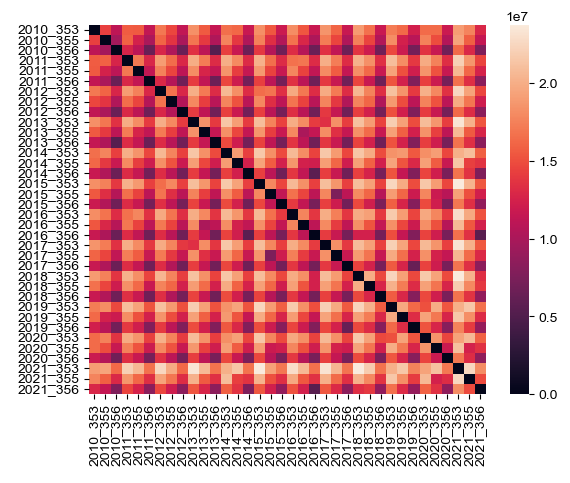

In [45]:
pairwise_heatmap(hamming_distances, h_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


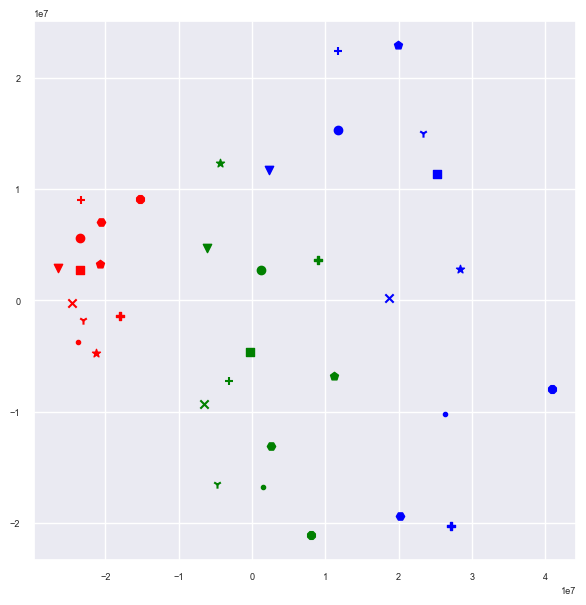

In [46]:
mds_projections(h_regions, hamming_distances)

In [47]:
num_same_classes, h_metagraph = get_metagraph(hamming_distances, h_labels, h_regions)
h_random_graphs = random_graphs(h_metagraph)
num_same_random = get_same_class_random(h_random_graphs)

fr_test(num_same_random, num_same_classes)

8.074514729958734e-06

### Jaccard Tests

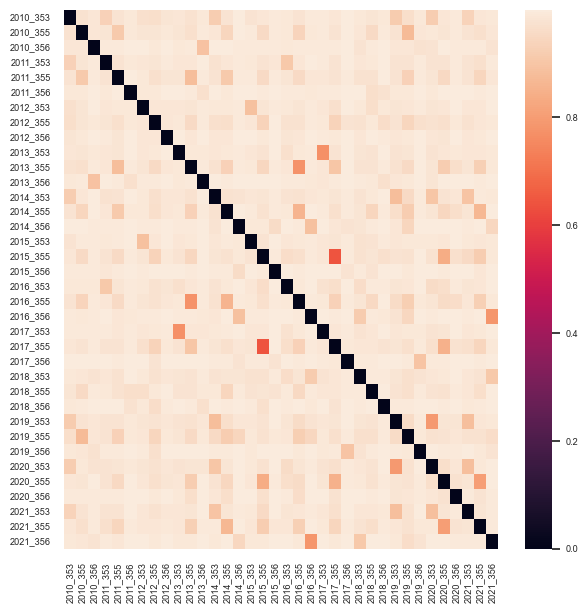

In [48]:
pairwise_heatmap(jaccard_distances, j_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


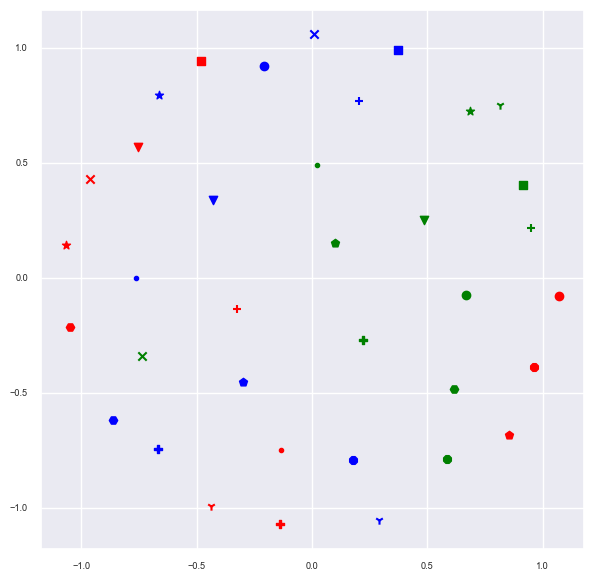

In [49]:
mds_projections(j_regions, jaccard_distances)

In [50]:
num_same_classes, j_metagraph = get_metagraph(jaccard_distances, j_labels, j_regions)
j_random_graphs = random_graphs(j_metagraph)
num_same_random = get_same_class_random(j_random_graphs)

fr_test(num_same_random, num_same_classes)

2.1545637328970787e-23

### Spanning Tree Tests

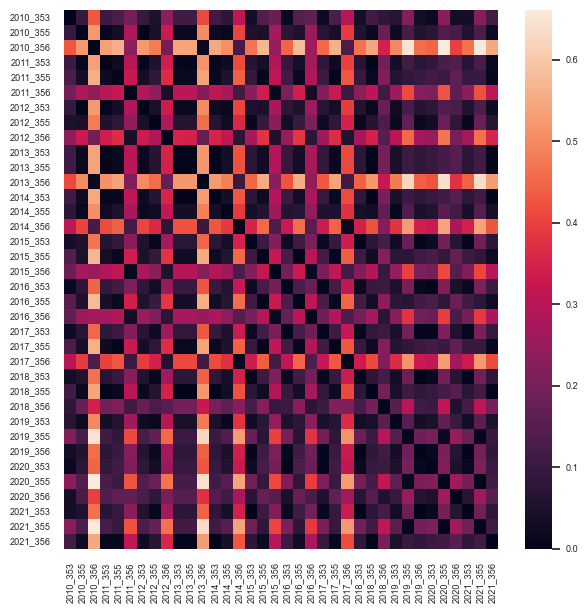

In [51]:
pairwise_heatmap(st_distances, st_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


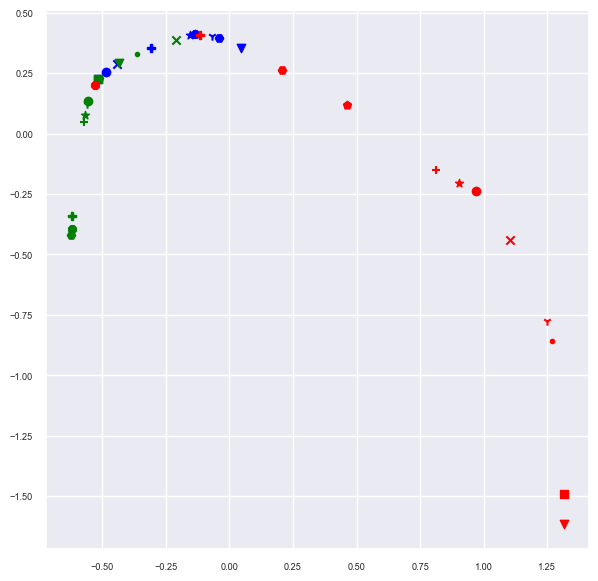

In [52]:
mds_projections(st_regions, st_distances)

In [53]:
num_same_classes, st_metagraph = get_metagraph(st_distances, st_labels, st_regions)
st_random_graphs = random_graphs(st_metagraph)
num_same_random = get_same_class_random(st_random_graphs)

fr_test(num_same_random, num_same_classes)

8.576205725011753e-14

### Polynomial Tests

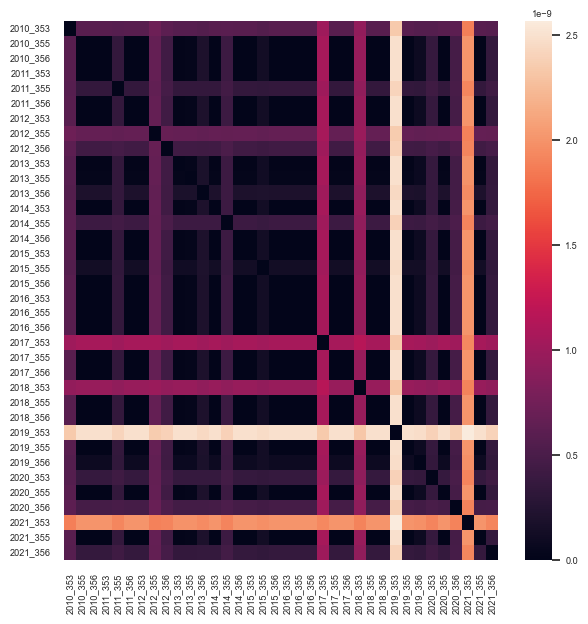

In [54]:
pairwise_heatmap(polynomial_distances, p_labels)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


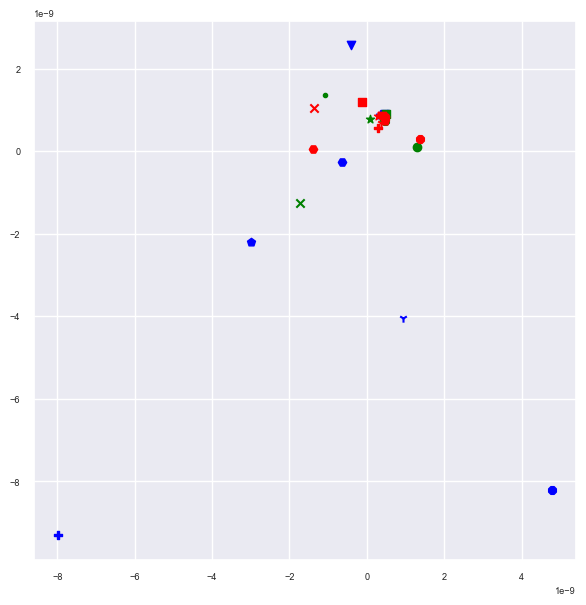

In [55]:
mds_projections(p_regions, polynomial_distances)

In [56]:
num_same_classes, p_metagraph = get_metagraph(polynomial_distances, p_labels, p_regions)
p_random_graphs = random_graphs(p_metagraph)
num_same_random = get_same_class_random(p_random_graphs)

fr_test(num_same_random, num_same_classes)

0.014383234476003494